In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as opt

### Make sure your runtime type is either GPU or TPU

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


The list of class names in the dataset

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3, 32, 32]) torch.Size([128])
truck


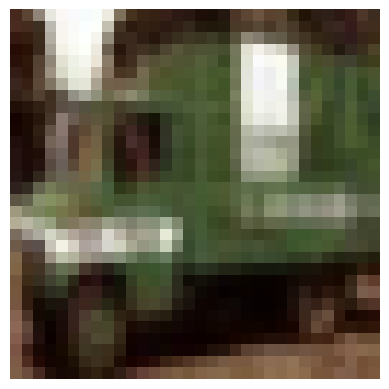

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size(), labels.size())

i = 12
imshow(images[i].permute([1, 2, 0]).numpy()/2 + .5)
axis('off')
print(classes[labels[i].item()])



---



## Task 1
Build a neural network with two *Linear* layers and an output layer. The first Linear layer should have 512 neurons and the second 128 neurons. Both layers should use *relu* activation function. After each of these *Linear* layers, you should have a *dropout* layer (torch.nn.Dropout) with dropout probability 0.2. The output layer
should be a *Linear* layer.

Use torch.nn.CrossEntropyLoss to compute the loss value of the model output. Use *adam* optimizer to update the model parameters when training the model.

In [ ]:
device = torch.device('cpu')

model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, len(classes))
).to(device)

CEL_loss = nn.CrossEntropyLoss()
optimizer = opt.Adam(model1.parameters())

## Task 2
Train the model for 50 epochs. Evaluate the model on the testing data. Print out the model accuracy on test data after the training.

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    model1.train()
    for i, (X,y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        pred = model1(X)
        loss = CEL_loss(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
            
    model1.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_test, y_test in testloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model1(X_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
            
    print(f'Accuracy on test data after epoch {epoch + 1}: {(100 * correct / total):.2f}%')
    
       

## Task 3
Implement a function *recognize*. It takes an image (shape = 3, 32, 32) as an input and use the "model" you trained above to make a prediction of the image's class. Your function should return the predicted (string) class (use the classes list above to map numeric prediction to string label).

In [ ]:
def recognize(new_img):
    model1.eval()
    im_tensor = torch.tensor(new_img).unsqueeze(0)
    with torch.no_grad():
        output = model1(im_tensor)
        
    _, predicted = torch.max(output, 1)
    return classes[predicted.item()]


dataiter = iter(testloader)
images, labels = next(dataiter)
new_img = images[0]

pred = recognize(new_img.cpu())

print('Neural network recognizes this image as:', pred)
print('true image label:', classes[labels[0].item()])
imshow(new_img.permute([1, 2, 0]).numpy()/2 + .5)
axis('off')

### Task 4

Implement a CNN with the following structure:
- 4 Conv layers:  
(3x3)x32, (3x3)x32, (3x3)x64, (3x3)x64

- 2x2 Maxpool after 2nd and 4th conv.
- Dropout after pooling
- One FC layer and then a FC output layer

Train the CNN model until training accuracy converges.
(Compute accuracy on training data at the end of each epoch. Plot the accuracy values vs epochs to determine whether it converges.) Test the accuracy of the trained model on the testing dataset.

In [7]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.5),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(128 * 8 * 8, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(cnn.parameters(), lr=0.001)

def train(model, trainloader, criterion, optimizer):
    epochs = 50
    train_accuracy = [] 
    prev_accuracy = 0.0 
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        train_accuracy.append(epoch_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {epoch_accuracy:.2f}%')

        if abs(epoch_accuracy - prev_accuracy) < 0.1:
            print("Training accuracy converged.")
            break

        prev_accuracy = epoch_accuracy

    return train_accuracy

def test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return test_accuracy

In [ ]:
train_accuracy = train(cnn, trainloader, criterion, optimizer)
test_accuracy = test(cnn, testloader)

plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()